# EDA of the last.fm dataset

<b>TL;DR:</b>
* Huge dataset, computational issues
* Names are sometimes spelled differently
* Sudden drop of listens in 2009
* Power-law distributions of number of entries per artist and track
* Missing id's for some artists (3%) and tracks (10%)

In [1]:
import pandas as pd
from zipfile import ZipFile
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from missingno import missingno
from utils import read_lastfm

In [2]:
songs, users = read_lastfm("data/lastfm-dataset-1K.zip")

In [3]:
songs.head()

,user_id,timestamp,artist_id,artist_name,track_id,track_name
0,user_000001,2009-05-04 23:08:57+00:00,f1b1cf71-bd35-4e99-8624-24a6e15f133a,Deep Dish,NaN,Fuck Me Im Famous (Pacha Ibiza)-09-28-2007
1,user_000001,2009-05-04 13:54:10+00:00,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Composition 0919 (Live_2009_4_15)
2,user_000001,2009-05-04 13:52:04+00:00,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Mc2 (Live_2009_4_15)
3,user_000001,2009-05-04 13:42:52+00:00,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Hibari (Live_2009_4_15)
4,user_000001,2009-05-04 13:42:11+00:00,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Mc1 (Live_2009_4_15)


In [5]:
users.head()

,user_id,gender,age,country,registered
0,user_000001,m,NaN,Japan,2006-08-13
1,user_000002,f,NaN,Peru,2006-02-24
2,user_000003,m,22.0,United States,2005-10-30
3,user_000004,f,NaN,NaN,2006-04-26
4,user_000005,m,NaN,Bulgaria,2006-06-29


# Optimization

Let's first convert all object dtypes to categorical. There is a big difference between to total count and the number of unique values so this will reduce the memory usage.

Note: analysis showed that converting to categorical is a huge improvement so I refactored the notebook to include the conversion in the data reading rather than in this section.

In [6]:
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

def convert_to_category(df, cols):
    print(mem_usage(df))
    for col in tqdm(cols):
        df.loc[:,col] = df[col].astype('category')
    print(mem_usage(df))

In [7]:
# convert_to_category(songs, df.columns.drop('timestamp'))

In [8]:
# songs.info(memory_usage=True)

# Listening history exploration

In [7]:
songs.describe(datetime_is_numeric=True)

,user_id,timestamp,artist_id,artist_name,track_id,track_name
count,19098862,19098862,18498009,19098862,16936136,19098850
unique,992,NaN,107295,173923,960402,1083480
top,user_000949,NaN,a74b1b7f-71a5-4011-9441-d0b5e4122711,Radiohead,db16d0b3-b8ce-4aa8-a11a-e4d53cc7f8a6,Intro
freq,183103,NaN,115099,115099,3991,17561
mean,NaN,2007-09-21 13:53:43.874962432+00:00,NaN,NaN,NaN,NaN
min,NaN,2005-02-14 00:00:07+00:00,NaN,NaN,NaN,NaN
25%,NaN,2006-11-23 19:35:10+00:00,NaN,NaN,NaN,NaN
50%,NaN,2007-10-21 10:29:44+00:00,NaN,NaN,NaN,NaN
75%,NaN,2008-08-22 08:22:24.249999872+00:00,NaN,NaN,NaN,NaN
max,NaN,2013-09-29 18:32:04+00:00,NaN,NaN,NaN,NaN


* There is almost 20 million rows, performance will be an issue during this project. 
* There are 100'000 different artists and 1 million different songs in the dataset.
* The time span covered by the dataset ranged from 2005 to 2013.
* The number of artist id's is not the same as the number of artist names, some artists may be represented by multiple names. Similarly for tracks.

## Distributions
Let's see how many entries in the dataset there are for users, artists and tracks respectively.

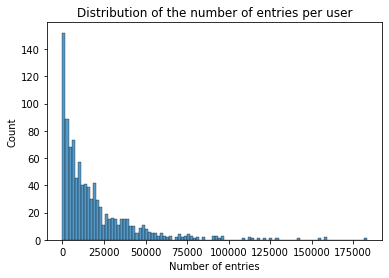

In [8]:
user_entries = songs.groupby('user_id').size().reset_index().rename(columns={0:'Number of entries'})
sns.histplot(data=user_entries, x='Number of entries', bins=100)
plt.title("Distribution of the number of entries per user")
plt.show()

This histogram counts the number of user which listened to different number of songs in the dataset. We can see that most of them listened to a few songs while some listened to more than 175'000 songs. The distribution looks exponential.

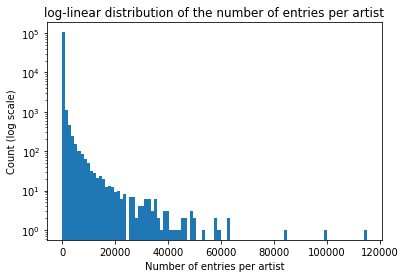

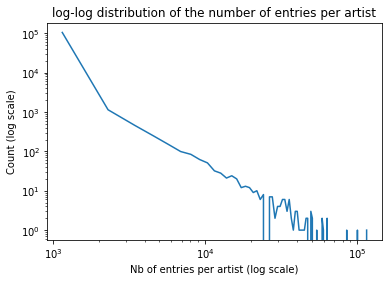

In [9]:
artist_entries = songs.groupby('artist_id').size().reset_index()
bins = plt.hist(artist_entries[0],bins=100,log=True,histtype='bar')
plt.title("log-linear distribution of the number of entries per artist")
plt.ylabel("Count (log scale)")
plt.xlabel("Number of entries per artist")
plt.show()
plt.loglog(bins[1][1:],bins[0])
plt.ylabel("Count (log scale)")
plt.xlabel("Nb of entries per artist (log scale)")
plt.title("log-log distribution of the number of entries per artist");

While the first graph looks similar to the distribution for users, this one uses a logarithmic scale for the y-axis. Thus, it is an even greater majority of artists that has very few entries in the dataset while a minority of them gets all the fame. Let's find out whose artists are the most recognized. We can recognize the power-law distribution at the approximately straight line on the log-log plot.

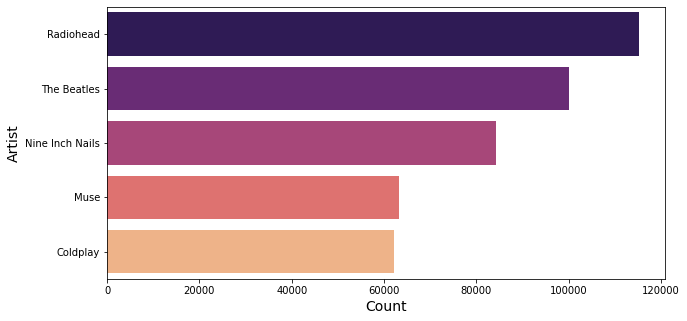

In [18]:
top_artists = artist_entries.sort_values(0, ascending=False).head(5) \
                            .merge(songs.drop_duplicates('artist_id'), on='artist_id')\
                            .rename(columns={0:'Count'})
top_artists['artist'] = top_artists.artist_name.astype('string')
plt.figure(figsize=(10,5))
sns.barplot(data=top_artists, y="artist", x="Count", orient='h', palette='magma');
plt.ylabel("Artist", fontsize=14)
plt.xlabel("Count",fontsize=14)
plt.savefig("top_artists.png", dpi=300, bbox_inches='tight')

We can see that users have a great taste.

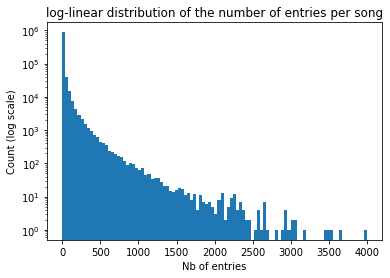

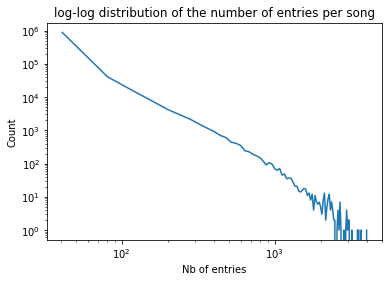

In [19]:
track_entries = songs.groupby('track_id').size().reset_index()
bins = plt.hist(track_entries[0],bins=100,log=True,histtype='bar')
plt.title("log-linear distribution of the number of entries per song")
plt.ylabel("Count (log scale)")
plt.xlabel("Nb of entries")
plt.show()
plt.loglog(bins[1][1:],bins[0])
plt.ylabel("Count")
plt.xlabel("Nb of entries")
plt.title("log-log distribution of the number of entries per song");

Here we can see the repartition of the number of times each song has been listened to in the dataset. An enormous majority of songs have very few listens while a few of them have a huge number of listens. This is a power-law distribution, we have to be careful while using non robust statistics.

Let's see which ones are the most listened too:

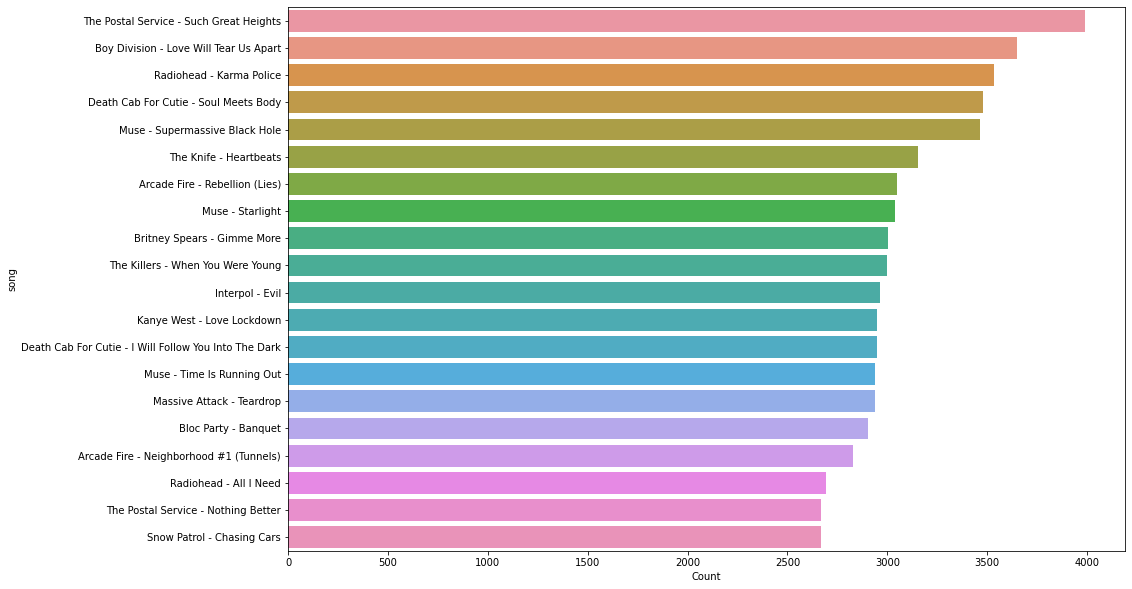

In [14]:
top_tracks = track_entries.sort_values(0, ascending=False).head(20) \
                            .merge(songs.drop_duplicates('track_id'), on='track_id')\
                            .rename(columns={0:'Count'})
top_tracks['song'] = top_tracks.artist_name.astype('string') + ' - '+ top_tracks.track_name.astype('string')
plt.figure(figsize=(15,10))
sns.barplot(data=top_tracks, y="song", x="Count", orient='h');

While Radiohead is the most listened group according the previous observations, it is only third for the top tracks, maybe by cumulating a lot of top_tracks. As a side note Love Lockdown by Kayne West took a whole new meaning nowadays.

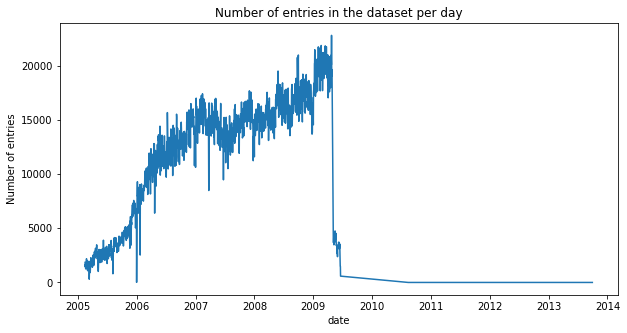

In [21]:
songs['date'] = songs.timestamp.dt.date
daily_entries = songs.groupby('date').size().reset_index()\
                     .rename(columns={0:'Number of entries'})
plt.figure(figsize=(10,5))
sns.lineplot(data=daily_entries, x='date', y='Number of entries')
plt.title("Number of entries in the dataset per day")
plt.savefig("dataset_duration.png", dpi=300, bbox_inches='tight')
plt.show()

This plot shows the number of listens per day. We can see an sudden drop during 2009. That is an important thing to note if we decide to explore a chronological aspect of the dataset.

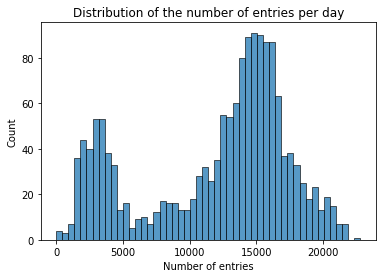

In [16]:
sns.histplot(data=daily_entries, x='Number of entries', bins=50)
plt.title("Distribution of the number of entries per day");

This histogram counts the number of entries per day. We can see two peaks, maybe the average number before and after the 2009 drop?

Let's see why the number of distinct artist id's is different from the number of distinct artist name (107295 vs 173921):

In [17]:
duplicates = songs.drop_duplicates(['artist_id', 'artist_name']).groupby('artist_id',).size()\
                    .reset_index().rename(columns={0:'Count'})
duplicates = duplicates[duplicates['Count'] > 1]
duplicates = songs.drop_duplicates(['artist_id', 'artist_name'])\
                    .merge(duplicates, on='artist_id')
duplicates[['artist_id', 'artist_name']].head(10)

,artist_id,artist_name
0,def226b0-7990-4b38-ab1a-7740461844dc,Yael Naim
1,def226b0-7990-4b38-ab1a-7740461844dc,Yael Naïm
2,7b290da1-03f2-4d91-8f6e-0e4930e39831,Mlle Caro & Franck Garcia
3,7b290da1-03f2-4d91-8f6e-0e4930e39831,Mlle Caro & Frank Garcia
4,66ea0139-149f-4a0c-8fbf-5ea9ec4a6e49,[Disney]
5,66ea0139-149f-4a0c-8fbf-5ea9ec4a6e49,Disney
6,ef03133a-8888-46ca-8675-45f11449f987,Die Lassie Singers
7,ef03133a-8888-46ca-8675-45f11449f987,Lassie Singers
8,1fda852b-92e9-4562-82fa-c52820a77b23,The Pussycat Dolls
9,1fda852b-92e9-4562-82fa-c52820a77b23,Pussycat Dolls


Unsurprisingly, these duplicates are due to different spellings of the artist names. That shows that we can only use the `artist_id` field as identifier.

In [79]:
duplicates = songs.drop_duplicates(['track_id', 'track_name']).groupby('track_id',).size()\
                    .reset_index().rename(columns={0:'Count'})
duplicates = duplicates[duplicates['Count'] > 1]
duplicates = songs.drop_duplicates(['track_id', 'track_name'])\
                    .merge(duplicates, on='track_id')
duplicates[['track_id', 'track_name']].head(10)

,user_id,timestamp,artist_id,artist_name,track_id,track_name,date,Count
0,user_000001,2008-08-21 14:55:24+00:00,15388d42-9197-4ca1-9ffe-240f763b84cb,Theo Parrish,5b0afc9d-8567-4723-9b1c-ec31f816135d,Brain,2008-08-21,2
1,user_000451,2008-03-13 00:56:00+00:00,15388d42-9197-4ca1-9ffe-240f763b84cb,Theo Parrish,5b0afc9d-8567-4723-9b1c-ec31f816135d,Brain Collaboration,2008-03-13,2
2,user_000002,2006-12-08 04:55:54+00:00,197450cd-0124-4164-b723-3c22dd16494d,Frank Sinatra,e0779db2-d84e-4d8c-b08e-ef2ab2b601cd,My Way,2006-12-08,2
3,user_000409,2008-06-27 00:36:44+00:00,197450cd-0124-4164-b723-3c22dd16494d,Frank Sinatra,e0779db2-d84e-4d8c-b08e-ef2ab2b601cd,My Way (Duet With Luciano Pavarotti),2008-06-27,2
4,user_000004,2007-07-09 20:43:36+00:00,c5a05cda-2f00-4566-9e1d-7b366fcdbfff,Oi Va Voi,0041fa4d-72e1-4464-a9df-ee0fb8b4d872,Gypsy,2007-07-09,2
5,user_000112,2008-06-13 04:56:37+00:00,c5a05cda-2f00-4566-9e1d-7b366fcdbfff,Oi Va Voi,0041fa4d-72e1-4464-a9df-ee0fb8b4d872,Gypsy (Feat. Earl Zinger),2008-06-13,2
6,user_000004,2007-05-11 22:50:02+00:00,e4c226f2-ba57-483f-be6b-3391112244b8,Mirah,08876672-c74e-4a2c-86f4-24e4325aff0a,Promise To Me,2007-05-11,2
7,user_000534,2008-03-26 18:38:44+00:00,e4c226f2-ba57-483f-be6b-3391112244b8,Mirah,08876672-c74e-4a2c-86f4-24e4325aff0a,Promise,2008-03-26,2
8,user_000010,2008-05-13 08:43:00+00:00,cc0b7089-c08d-4c10-b6b0-873582c17fd6,System Of A Down,391f0b31-0235-40d0-83e1-42e14fdc7e9c,A.D.D.,2008-05-13,2
9,user_000886,2007-10-19 10:23:38+00:00,cc0b7089-c08d-4c10-b6b0-873582c17fd6,System Of A Down,391f0b31-0235-40d0-83e1-42e14fdc7e9c,A.D.D. (American Dream Denial),2007-10-19,2


Similarly for the track names.

Let's check the percentage of missing values:

In [19]:
100 * songs.isna().sum() / len(songs)

user_id         0.000000
timestamp       0.000000
artist_id       3.145990
artist_name     0.000000
track_id       11.323816
track_name      0.000063
date            0.000000
dtype: float64

It looks like a lot of id's are missing. At least most of the names are registered, we may be able to recover the id's from duplicates. That will be easier for artist id's than track id's.

In [20]:
songs[songs.artist_id.isna() & ~songs.track_id.isna()]

,user_id,timestamp,artist_id,artist_name,track_id,track_name,date


Remarkably, all rows with missing artist id also have missing track id.

In [21]:
songs[songs.track_name.isna()]

,user_id,timestamp,artist_id,artist_name,track_id,track_name,date
1264044,user_000060,2006-04-19 10:41:44+00:00,1f4bf518-3aa3-4114-ada7-64884e580ad2,The Sammies,NaN,NaN,2006-04-19
1371571,user_000067,2006-06-08 13:17:00+00:00,945c0e49-8d06-4f01-87cf-c2d82b00d5ac,Simon Dawes,NaN,NaN,2006-06-08
1371606,user_000067,2006-06-07 18:25:19+00:00,945c0e49-8d06-4f01-87cf-c2d82b00d5ac,Simon Dawes,NaN,NaN,2006-06-07
1371738,user_000067,2006-06-06 14:09:10+00:00,945c0e49-8d06-4f01-87cf-c2d82b00d5ac,Simon Dawes,NaN,NaN,2006-06-06
1371955,user_000067,2006-05-30 14:02:33+00:00,945c0e49-8d06-4f01-87cf-c2d82b00d5ac,Simon Dawes,NaN,NaN,2006-05-30
1372180,user_000067,2006-05-25 16:14:33+00:00,1f4bf518-3aa3-4114-ada7-64884e580ad2,The Sammies,NaN,NaN,2006-05-25
1372494,user_000067,2006-05-15 20:20:25+00:00,945c0e49-8d06-4f01-87cf-c2d82b00d5ac,Simon Dawes,NaN,NaN,2006-05-15
1372970,user_000067,2006-04-13 19:47:12+00:00,1f4bf518-3aa3-4114-ada7-64884e580ad2,The Sammies,NaN,NaN,2006-04-13
1373492,user_000067,2006-03-21 16:41:56+00:00,945c0e49-8d06-4f01-87cf-c2d82b00d5ac,Simon Dawes,NaN,NaN,2006-03-21
1373526,user_000067,2006-03-20 21:08:07+00:00,1f4bf518-3aa3-4114-ada7-64884e580ad2,The Sammies,NaN,NaN,2006-03-20


The rows with missing track name look similar: most are from the same user and from the same artist.

# User demographics

In [22]:
users.describe(include='all', datetime_is_numeric=True)

,user_id,gender,age,country,registered
count,992,884,286.000000,907,984
unique,992,2,NaN,66,NaN
top,user_000001,m,NaN,United States,NaN
freq,1,502,NaN,228,NaN
mean,NaN,NaN,25.367132,NaN,2006-02-18 21:05:51.219512320
min,NaN,NaN,3.000000,NaN,2002-10-29 00:00:00
25%,NaN,NaN,21.000000,NaN,2005-08-14 00:00:00
50%,NaN,NaN,23.000000,NaN,2006-03-03 12:00:00
75%,NaN,NaN,28.000000,NaN,2006-08-30 06:00:00
max,NaN,NaN,103.000000,NaN,2009-11-05 00:00:00


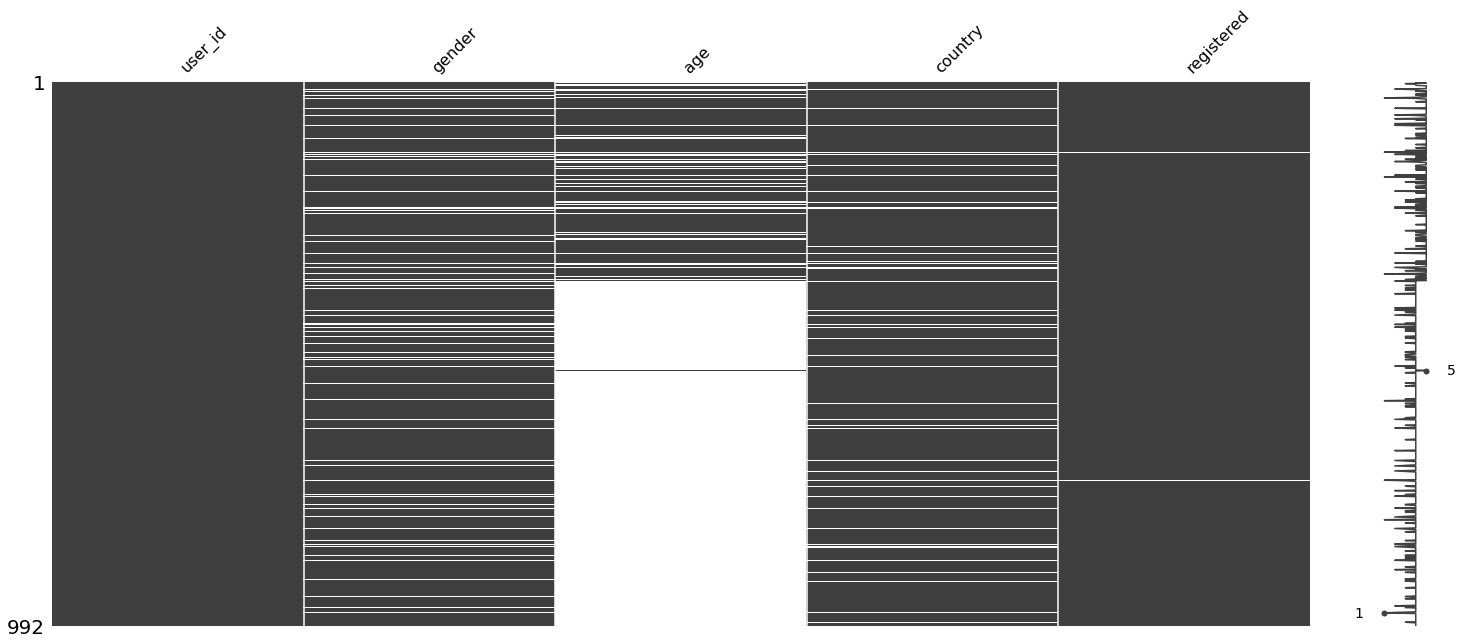

In [23]:
missingno.matrix(users)
plt.show()

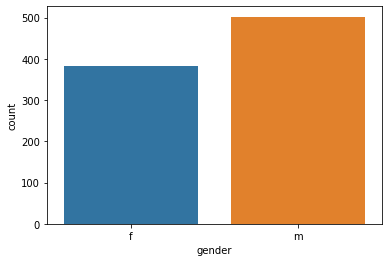

In [24]:
sns.countplot(data=users, x='gender');

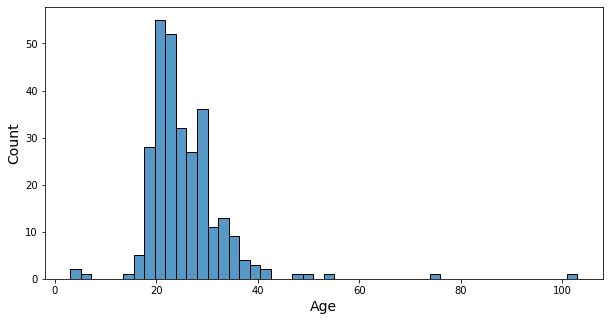

In [24]:
plt.figure(figsize=(10,5))
sns.histplot(data=users, x='age');
plt.ylabel("Count", fontsize=14)
plt.xlabel("Age",fontsize=14)
plt.savefig("age_distribution.png", dpi=300, bbox_inches='tight')

Interestingly, some users are really young and one is really old.

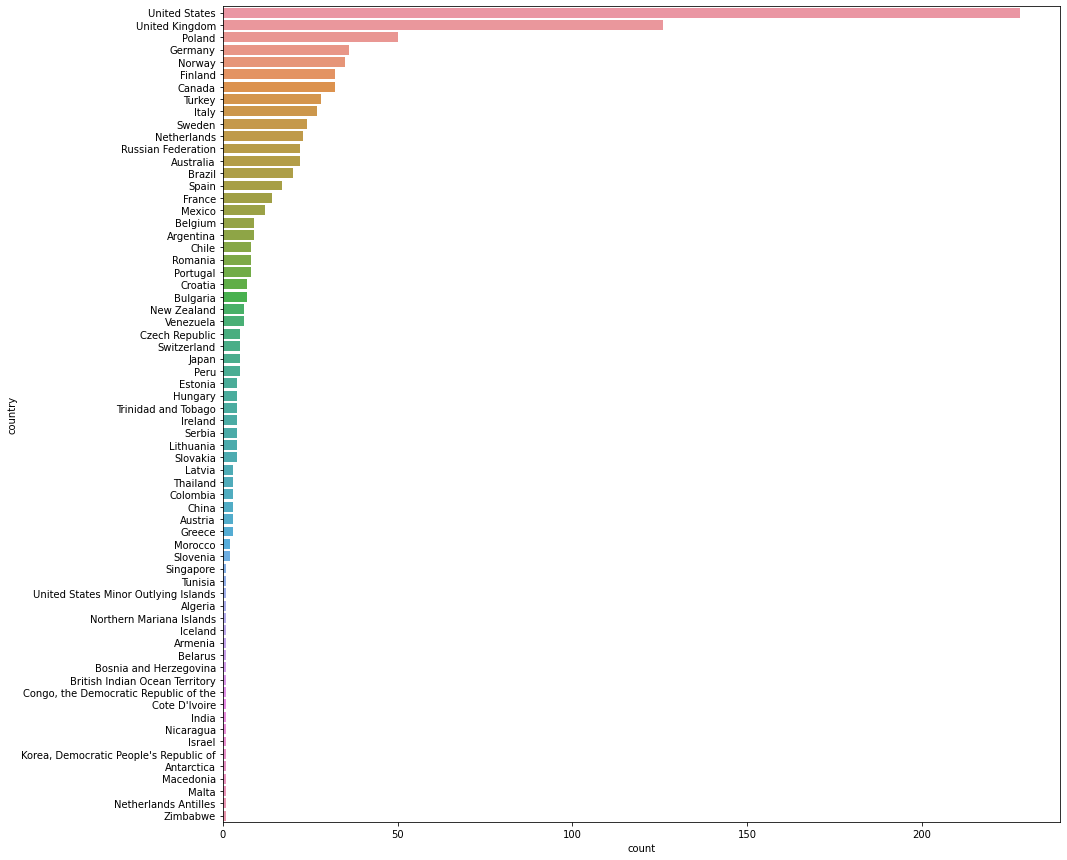

In [26]:
plt.figure(figsize=(15,15))
sns.countplot(data=users, y='country', orient='h', 
              order = users['country'].value_counts().index);

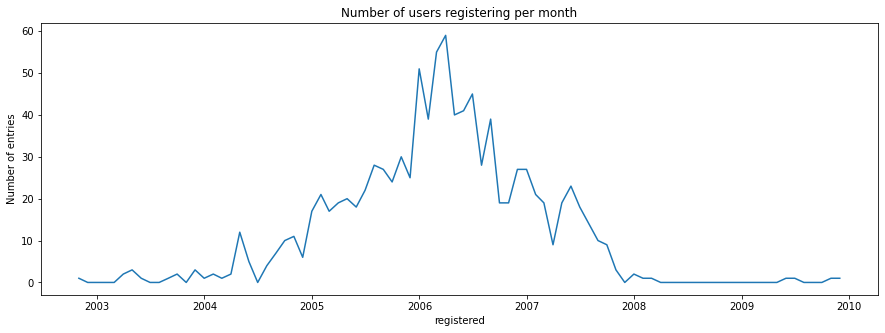

In [27]:
daily_entries = users.groupby(pd.Grouper(key='registered', freq='1M')).size().reset_index()\
                     .rename(columns={0:'Number of entries'})
plt.figure(figsize=(15,5))
sns.lineplot(data=daily_entries, x='registered', y='Number of entries')
plt.title("Number of users registering per month")
plt.show()

Most user registered between 2005 to 2008. Note that while the track history goes up to 2014, the last user in the dataset registered in 2010.

# Last.fm API exploration

In [25]:
import requests
import json
import urllib.parse
API_KEY = '471bf4b3afffd1b470553bbc6b26bef8'

## track.getTopTags

In [67]:
songs.tail()

,user_id,timestamp,artist_id,artist_name,track_id,track_name,date
19098848,user_001000,2008-01-27 22:02:35+00:00,9e53f84d-ef44-4c16-9677-5fd4d78cbd7d,Wilco,a490cabc-1e5c-4807-86c7-740c31a50009,Please Be Patient With Me,2008-01-27
19098849,user_001000,2008-01-27 21:56:52+00:00,9e53f84d-ef44-4c16-9677-5fd4d78cbd7d,Wilco,3e92e447-9e1f-440d-bc00-6734469880c5,Shake It Off,2008-01-27
19098850,user_001000,2008-01-27 21:52:36+00:00,9e53f84d-ef44-4c16-9677-5fd4d78cbd7d,Wilco,93d044e6-1bbb-46a6-ac8e-283382a89e6f,Side With The Seeds,2008-01-27
19098851,user_001000,2008-01-27 21:49:12+00:00,9e53f84d-ef44-4c16-9677-5fd4d78cbd7d,Wilco,5ac4386f-6146-4389-a762-4b43f362d2c8,Sky Blue Sky,2008-01-27
19098852,user_001000,2008-01-27 21:43:14+00:00,9e53f84d-ef44-4c16-9677-5fd4d78cbd7d,Wilco,3acc99bc-a349-420f-ad28-7095eb3533c9,Impossible Germany,2008-01-27


In [89]:
def getTrackTags(artist=None, track=None, track_id=None, threshold=10):
    artist = urllib.parse.quote(artist)
    track = urllib.parse.quote(track)
    url = f"http://ws.audioscrobbler.com/2.0/?method=track.gettoptags&artist={artist}&track={track}&api_key={API_KEY}&format=json&autocorrect=1"
    response = requests.get(url).json()['toptags']
    print(response['@attr']['artist'] + ' - '+ response['@attr']['track'])
    for tag_item in response['tag']:
        count = tag_item['count']
        if count >= threshold:
            print(tag_item['name'], count)
    return response['tag']

In [76]:
getTrackTags('RadioHead', 'Paranoid Android')

Radiohead - Paranoid Android
alternative 100
alternative rock 87
rock 69
radiohead 56
indie 48
90s 30
british 28
experimental 18
indie rock 16
electronic 12
britpop 12
epic 11
Progressive rock 11
favorites 10


In [82]:
getTrackTags('Frank Sinatra', 'My way (Duet With Luciano Pavarotti)')

Frank Sinatra - My Way
jazz 100
oldies 81
frank sinatra 81
swing 60
easy listening 45
My Way 24
60s 17
classic 13
vocal jazz 13
male vocalists 13
american 10


In [77]:
getTrackTags('坂本龍一', 'Composition 0919 (Live_2009_4_15)', threshold=1)

坂本龍一 - composition 0919 (live_2009_4_15)


In [78]:
getTrackTags('Deep Dish', 'Fuck Me Im Famous (Pacha Ibiza)-09-28-2007')

Deep Dish - Fuck Me Im Famous (Pacha Ibiza)-09-28-2007
dance 100
House 100


We can use the `autocorrect` parameter to have the right title names

## Tag extraction

In [90]:
getTrackTags('Deep Dish', 'Fuck Me Im Famous (Pacha Ibiza)-09-28-2007')

[{'count': 100, 'name': 'dance', 'url': 'https://www.last.fm/tag/dance'},
 {'count': 100, 'name': 'House', 'url': 'https://www.last.fm/tag/House'}]

In [9]:
discography = songs[['artist_name', 'track_name']].drop_duplicates()

In [10]:
discography.head()

,artist_name,track_name
0,Deep Dish,Fuck Me Im Famous (Pacha Ibiza)-09-28-2007
1,坂本龍一,Composition 0919 (Live_2009_4_15)
2,坂本龍一,Mc2 (Live_2009_4_15)
3,坂本龍一,Hibari (Live_2009_4_15)
4,坂本龍一,Mc1 (Live_2009_4_15)


In [11]:
def extract_track_tag(df):
    data = []
    for i, row in tqdm(df.iterrows()):
        artist = row['artist_name']
        track = row['track_name']
        try:
            res = getTrackTags(artist, track)
            tags = {item['name']: item['count'] for item in res}
            data.append([artist, track, tags])
        except Exception:
            print(f'Exception for {artist} - {track}')
            continue

    return pd.DataFrame(data=data, columns=['artist_name', 'track_name', 'tags'])

In [106]:
tags = extract_tag(discography.iloc[810:813])

3it [00:01,  2.34it/s]

Exception for Spencer Bohren - Hip Hoperation/Plateau


Extracting the tag runs at aroung 6 iterations per second. There is 1 million tracks, it would take 48 hours to extract all the tags.

# Artist tag extraction

In [12]:
artists = discography.artist_name.drop_duplicates().to_frame()

In [13]:
artists.head()

,artist_name
0,Deep Dish
1,坂本龍一
14,Underworld
16,Ennio Morricone
17,Minus 8


In [49]:
def get_artist_tags(artist):
    artist = urllib.parse.quote(artist)
    url = f"http://ws.audioscrobbler.com/2.0/?method=artist.gettoptags&artist={artist}&api_key={API_KEY}&format=json&autocorrect=1"
    response = requests.get(url).json()
    if 'error' not in response:
        return response['toptags']['tag']
    else:
        return None

In [50]:
def extract_artist_tags(df):
    data = []
    for i, row in tqdm(df.iterrows()):
        artist = row['artist_name']
        try:
            res = get_artist_tags(artist)
            tags = {item['name']: item['count'] for item in res}
            data.append([artist, res])
        except Exception as e:
            exception = e
            print(f'Exception at index {i}: {artist}')
            continue

    pd.DataFrame(data=data, columns=['artist_name', 'tags']).to_csv("artist_tags.csv")
    return exception

In [ ]:
exception = extract_artist_tags(artists)

In [52]:
exception

TypeError("'NoneType' object is not iterable")

Extracting all the artist tags would take around 8 hours.